# Modelo RandomForest

En este JN voy a desarrollar y entrenar mi modelo, obteniendo las principales métricas tanto de las base de datos como del propio modelo, para terminar guardándolo y así poder utilizarlo para realizar predicciones de nuevos sonidos.

De todas formas, en JN voy a aplicarle al modelo PCA para saber si existe alguna mejora alternativa que le pueda aplicar a mi modelo.

Empiezo importando las librerías que voy a utilizar.

In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

import pickle

In [6]:
# data1 = pd.read_csv('./Sonidos de casa/data_momento_aux.csv')
# data2 = pd.read_csv('./Sonidos de casa/data_momento_aux_shaver.csv')
# data3 = pd.read_csv('./Sonidos de casa/data_momento_aux_hairdryer.csv')
# data4 = pd.read_csv('./Sonidos de casa/data_momento_aux_airconditioner.csv')
# data5 = pd.read_csv('./Sonidos de casa/data_momento_aux_cellphone.csv')
# data6 = pd.read_csv('./Sonidos de casa/data_momento_aux_comp_type.csv')
# data7 = pd.read_csv('./Sonidos de casa/data_momento_aux_shower.csv')
# data8 = pd.read_csv('./Sonidos de casa/data_momento_aux_vacuum_silence_dryer.csv')
# data9 = pd.read_csv('./Sonidos de casa/data_momento_aux_blender_doorbell.csv')
# data10 = pd.read_csv('./Sonidos de casa/data_momento_aux_alarm_faucet_microwave.csv')

# data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10])

# data.to_csv('data.csv', index=False)

A continuación he creado 3 funciones que me dan lo siguiente:
 - La primera me lee el dataset sobre el que voy a trabajar.
 - La segunda me muestra las principales métricas y características de la base de datos.
 - Y la tercera crea dos gráficos, el primero es una correlation matrix entre las diferentes features del dataset, y el segundo me muestra la relación entre cada una de las features y cómo es esta relación y su distribución.

In [3]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')

In [5]:
def show_df_info(dataframe):
    display("The type of the dataframe is {}.".format(type(dataframe)))
    print("------------------------------------------------------------------------")
    display("The amount of entries are {}.".format(dataframe.size))
    print("------------------------------------------------------------------------")
    display("Its shape is {}.".format(dataframe.shape))
    print("------------------------------------------------------------------------")
    display("Its features are: {}.".format(list(dataframe)))
    print("------------------------------------------------------------------------")
    print("The data types of columns are: {}".format(dataframe.dtypes))
    print("------------------------------------------------------------------------")
    print("The counter of each class is: {}".format(dataframe.momento_aux.value_counts()))
    print("------------------------------------------------------------------------")
    print('The amount of null values is: {}.'.format(dataframe.isna().sum()))
    display(dataframe.head())
    display(dataframe.describe())
    
show_df_info(data)

"The type of the dataframe is <class 'pandas.core.frame.DataFrame'>."

------------------------------------------------------------------------


'The amount of entries are 23688.'

------------------------------------------------------------------------


'Its shape is (2961, 8).'

------------------------------------------------------------------------


"Its features are: ['mfcc', 'scem', 'scom', 'srom', 'sbwm', 'tempo', 'rmse', 'momento_aux']."

------------------------------------------------------------------------
The data types of columns are: mfcc           float64
scem           float64
scom           float64
srom           float64
sbwm           float64
tempo          float64
rmse           float64
momento_aux     object
dtype: object
------------------------------------------------------------------------
The counter of each class is: Lavadora              244
Licuadora             208
Secadora              196
Tecleo                196
Alarma                194
Grifo                 185
Timbre                183
Microondas            183
Ducha                 183
Secador_pelo          183
Afeitadora            182
Aire_acondicionado    182
Silencio              181
Aspiradora            179
Telefono              152
Cena                  130
Name: momento_aux, dtype: int64
------------------------------------------------------------------------
The amount of null values is: mfcc           0
scem           0
scom      

,mfcc,scem,scom,srom,sbwm,tempo,rmse,momento_aux
0,8.496989,712.836354,20.288098,821.184439,1649.203780,123.046875,0.224968,Lavadora
1,-0.570672,3331.769238,17.851447,6729.850411,2802.241131,123.046875,0.142873,Aspiradora
2,-33.519966,3041.652499,25.822745,4911.568754,1606.222710,135.999178,0.013394,Ducha
3,4.767383,1660.236818,18.631205,4236.657715,2572.411617,120.000000,0.142544,Lavadora
4,4.888659,881.912702,17.027614,1765.397910,1488.700377,117.453835,0.128794,Lavadora


,mfcc,scem,scom,srom,sbwm,tempo,rmse
count,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000
mean,-9.298735,2557.744559,19.635431,4833.775799,2183.997756,124.919987,0.092519
std,10.146918,1488.022002,3.483622,2707.707056,759.975619,14.340122,0.075292
min,-56.568542,0.000000,0.000000,0.000000,0.000000,83.354335,0.000000
25%,-15.975185,1262.656881,17.409630,2157.916727,1592.859134,117.453835,0.028839
50%,-8.861495,2570.938461,18.696572,5052.009204,2455.881733,123.046875,0.068703
75%,-2.466966,3424.361834,21.537844,7380.392959,2808.579298,129.199219,0.151704
max,9.566074,6438.882531,37.151258,9727.624512,3437.618460,215.332031,0.288975


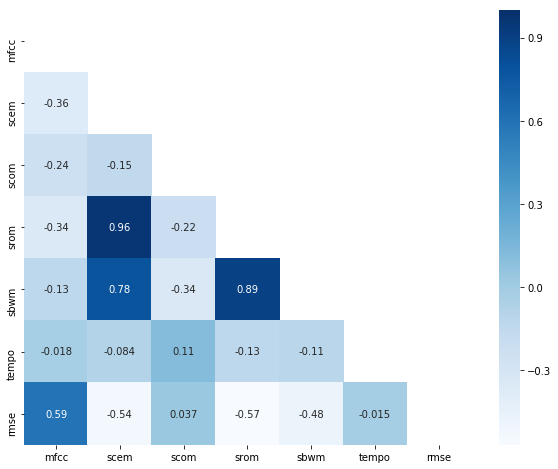

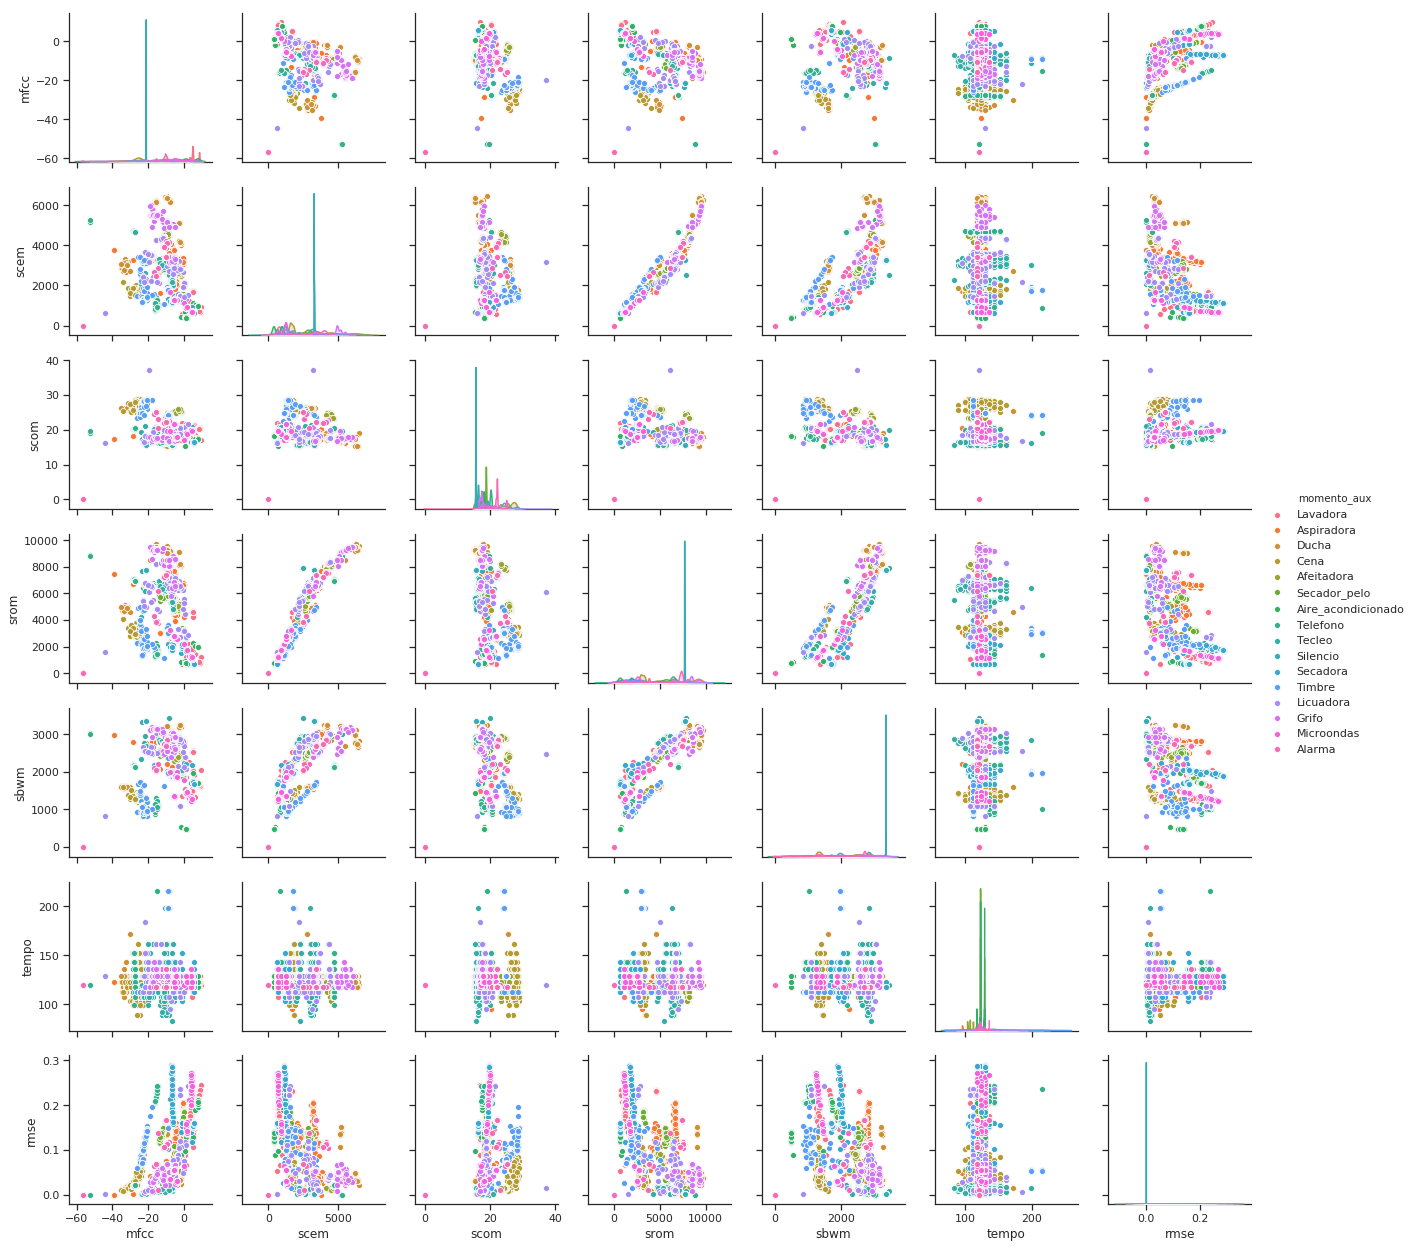

In [6]:
def get_matrix(dataset, classes):
    mask = np.zeros_like(dataset.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(dataset.corr(), mask=mask, annot=True, cmap="Blues")

    sns.set(style="ticks")
    sns.pairplot(dataset, hue=classes)
    
get_matrix(data, 'momento_aux')

# Modelo

A partir de este momento es cuando empiezo a preparar y entrenar el modelo.

La dinámica es la que hemos seguido siempre, por lo que no voy a entrar en detalles que ya todos conocemos. Simplemente me limitaré a comentar los resultados y a epxlicar código que no haya sido utilizado previamente.

In [8]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=60))
scores = cross_val_score(model, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.97986577 0.91216216 0.93918919 0.95945946 1.         0.92567568
 0.98648649 0.14189189 0.96621622 0.9527027  0.98648649 0.9527027
 0.97297297 0.93243243 0.84459459 0.91891892 0.97972973 1.
 0.9527027  0.95945946]
Accuracy: 0.91 (+/- 0.36)


A la luz del accuracy anterior y del score del modelo, se puede ver claramente que se trata de un modelo con gran capacidad predictiva.

In [29]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9578414839797639

Con el siguiente código guardo mi modelo ya entrenado para poder utilizarlo a la hora de realizar predicciones, ahorrando así cálculos y tiempo.

In [30]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Como podemos observar, los errores son bastante pequeños, lo cual era algo de esperar.

In [11]:
predictions = model.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: Afeitadora            0.00
Aire_acondicionado    0.00
Alarma                0.00
Aspiradora            0.02
Cena                  0.00
Ducha                 0.00
Grifo                 0.00
Lavadora              0.01
Licuadora             0.00
Microondas            0.00
Secador_pelo          0.00
Secadora              0.00
Silencio              0.00
Tecleo                0.00
Telefono              0.00
Timbre                0.00
dtype: float64 degrees.


A continuación, dado que para este tipo de modelos no podemos aplicar un OLS para saber cómo de relevante es cada feature en nuestro modelo, he aplicado otra función llamada 'feature_importances_' que me permite obtener la relevancia de cada feature.

De todas formas, esta función ni funciona si al modelo le aplico un OneVsRestClassifier() como he hecho antes, por lo que se los que quitado con el fin de obtener al menos un cálculo estimado. De todas formas, no sé si es la forma correcta de proceder en este caso.

Como podemos ver en los resultados, todas las features tienen cierta relevancia, por lo que deshecho una idea que tenía en la cabeza que era la de eliminar o bien la feature 'srom' o bien 'scem', debido a la alta correlación entre ellos. Pero dado que ambas tiene una importancia relevante en el modelo, he decidido no deshacerme de ninguna de las dos.

In [12]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)
cls.fit(X_train, y_train)
importances = cls.feature_importances_
cls.score(X_test, y_test)

0.9679595278246206

In [13]:
std = np.std([tree.feature_importances_ for tree in cls.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

display(pd.DataFrame(cls.feature_importances_, 
                     index = X_train.columns, 
                     columns = ['importance']).sort_values('importance', ascending=False))

Feature ranking:
1. feature 2 (0.201274)
2. feature 4 (0.183685)
3. feature 0 (0.163249)
4. feature 6 (0.153998)
5. feature 1 (0.150525)
6. feature 3 (0.118841)
7. feature 5 (0.028428)


,importance
scom,0.201274
sbwm,0.183685
mfcc,0.163249
rmse,0.153998
scem,0.150525
srom,0.118841
tempo,0.028428


Y a continuación complemento un poco más en análisis anterior y muestro también la desviación estandar de cada feature, juntos con su importancia.

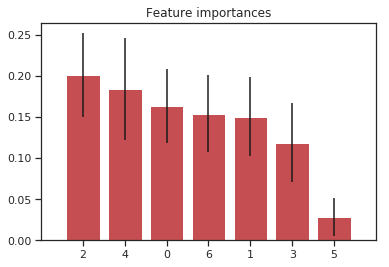

In [14]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Sin entrar mucho más en detalle, podemos continuar corroborando que el modelo falla muy poco a la hora de predecir, como se puede observar en los siguientes scores.

In [15]:
actual_values = y_test.values.argmax(axis=1)
predictions = model.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9595278246205734

In [16]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9623068912379907

In [17]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento'
precision_recall

,precision,recall,f1_score
momento,,,
Cena,0.633333,1.000000,0.775510
Ducha,1.000000,0.972973,0.986301
Lavadora,1.000000,0.972222,0.985915
Aspiradora,0.968750,0.756098,0.849315
Afeitadora,1.000000,0.968750,0.984127
Secador_pelo,1.000000,1.000000,1.000000
Aire_acondicionado,1.000000,0.955556,0.977273
Telefono,0.977778,0.956522,0.967033
Tecleo,1.000000,0.973684,0.986667


Como se va a poder ver en el gráfico de debajo, el modelo ha fallado muy poco prediciendo, sobre todo con la clase 'Licuadora', que a veces las clasifica como 'Afeitadora' debido a la similitud de ambos sonidos.

Confusion matrix, without normalization
[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0 37  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0 41  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 27  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 32  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0 42  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 32  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 32]]


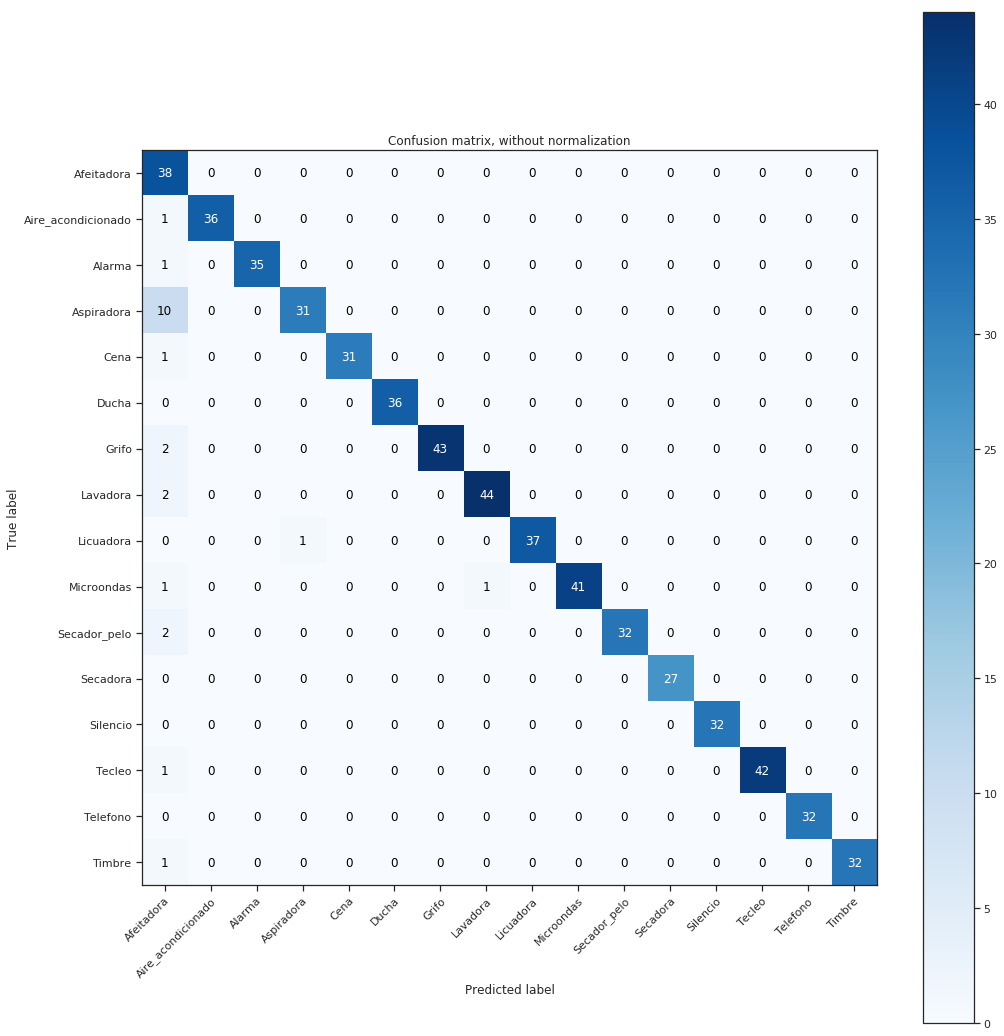

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

Y para terminar con el análisis de nuestro modelo, calculamos y graficamos las ROC Curves. Y como se ve en los resultados, el AUC para cada una de las clases es casi siempre del 100%.

Por lo que finalmente podemos conclir que tenemos un modelo bastante bueno y predictivo.

In [19]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [21]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [23]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [24]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [25]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [26]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

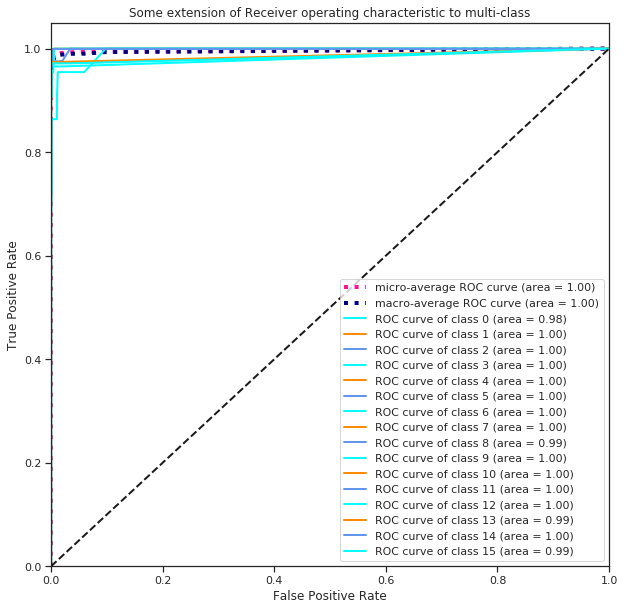

In [27]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Visualizing a Single Decision Tree

In [33]:
cls = RandomForestClassifier(n_estimators=40, random_state=0)

In [34]:
y = pd.get_dummies(data=data.momento)
X = data.loc[:, data.columns != 'momento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [69]:
from sklearn.tree import export_graphviz
import pydot

In [72]:
tree = cls.estimators_[5]

In [ ]:
feature_list = list(features.columns)

In [73]:
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

NameError: name 'feature_list' is not defined